## Goal: iin the kallisto quantification for the GENCODE annotation, check how highly-expressed / how many reads we get for rRNAs 

This is because we don't have the rRNAs in PODER

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [4]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [5]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [26]:
f = proc_cfg(config['lr']['v47_kallisto']['quant']['gene_tsv'],od)
gc_gtf = proc_cfg(config['ref']['gtf'], od)

df = pd.read_csv(f, sep='\t')

In [11]:
gtf_df = pr.read_gtf(gc_gtf).df
gtf_df = gtf_df.loc[gtf_df.Feature=='gene']
gtf_df['geneid.v'] = gtf_df.gene_id

In [27]:
df = df.merge(gtf_df[['geneid.v', 'gene_type']],
              on='geneid.v', 
              how='left')
assert len(df.loc[df.gene_type.isnull()].index) == 0

In [28]:
df.drop('geneid.v', axis=1, inplace=True)
df['rRNA'] = df.gene_type=='rRNA'
df.drop('gene_type', axis=1, inplace=True)
df = df.groupby('rRNA').sum().reset_index()
df.head()

,rRNA,AJI1,AJI2,AJI3,AJI4,AJI5,AJI6,CEU1,CEU2,CEU3,...,PEL3,PEL4,PEL5,PEL6,YRI1,YRI2,YRI3,YRI5,YRI6,YRI7
0,False,1.072755e+07,1.133012e+07,1.237527e+07,8.336032e+06,1.643787e+07,1.655362e+07,1.128379e+07,1.168477e+07,9.509226e+06,...,1.455014e+07,1.335160e+07,2.100703e+07,7.309462e+06,8.867219e+06,1.540718e+07,9.894960e+06,8.035526e+06,8.168138e+06,1.299089e+07
1,True,2.000000e+00,1.800000e+01,1.400000e+01,2.400000e+01,2.800000e+01,7.000000e+00,6.000000e+00,1.694118e+01,2.000000e+00,...,5.000000e+00,8.000000e+00,1.182500e+02,4.800000e+01,7.300000e+01,4.194118e+01,0.000000e+00,1.100000e+01,1.000000e+00,6.100000e+01


In [29]:
df.set_index('rRNA', inplace=True)
df = df.transpose()
df.head()

rRNA,False,True
AJI1,1.072755e+07,2.0
AJI2,1.133012e+07,18.0
AJI3,1.237527e+07,14.0
AJI4,8.336032e+06,24.0
AJI5,1.643787e+07,28.0


In [31]:
df['total'] = df[False]+df[True]
df['perc_rrna'] = (df[True]/df['total'])*100
df.head()

rRNA,False,True,total,perc_rrna
AJI1,1.072755e+07,2.0,1.072755e+07,0.000019
AJI2,1.133012e+07,18.0,1.133013e+07,0.000159
AJI3,1.237527e+07,14.0,1.237528e+07,0.000113
AJI4,8.336032e+06,24.0,8.336056e+06,0.000288
AJI5,1.643787e+07,28.0,1.643789e+07,0.000170


In [32]:
meta_df = load_meta()
df = df.merge(meta_df[['sample', 'population']], 
              how='left',
              left_index=True, 
              right_on='sample')
c_dict, order = get_population_colors()

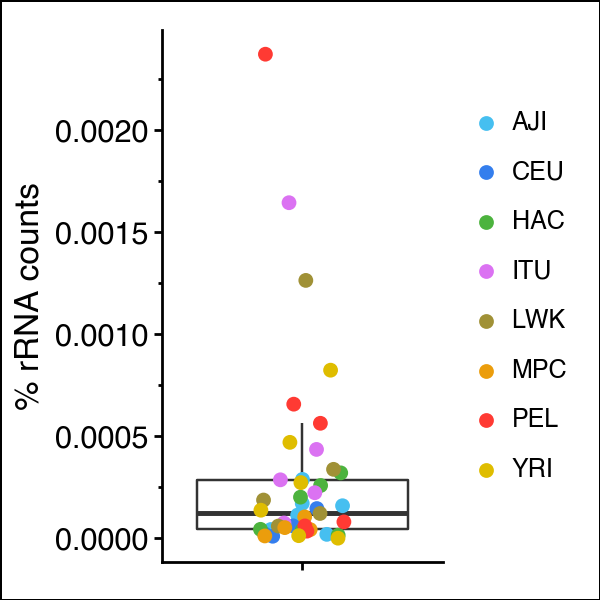

In [39]:
(
    ggplot(df, aes(y='perc_rrna', x="''"))
    + geom_boxplot(outlier_alpha=0)
    + labs(
        y='% rRNA counts',
        x=''
    )
    + geom_jitter(aes(color='population'), width=0.15, size=2)  # colored dots
    + scale_color_manual(values=c_dict)
    + my_theme(w=3, h=3)
)